In [9]:
import yaml
import piff
import ngmix
import proplot as pplt
import numpy as np
import os
import galsim

In [114]:
tilename = "DES2041-5248"
band = "r"

ypth = os.path.join(
    "/gpfs02/astro/workarea"
    "/beckermr/MEDS_DIR/des-pizza-slices-y6-v15/pizza_cutter_info",
    "%s_%s_pizza_cutter_info.yaml" % (tilename, band)
)

with open(ypth, "r") as fp:
    info = yaml.safe_load(fp)

In [115]:
def _compute_psf_stamp_bounds(x, y, dim):
    # compute the lower left corner of the stamp
    # we find the nearest pixel to the input (x, y)
    # and offset by half the stamp size in pixels
    # assumes the stamp size is odd
    # there is an assert for this below
    half = (dim - 1) / 2
    x_cen = np.floor(x+0.5)
    y_cen = np.floor(y+0.5)

    # make sure this is true so pixel index math is ok
    assert y_cen - half == int(y_cen - half)
    assert x_cen - half == int(x_cen - half)

    # compute bounds in Piff wcs coords
    xmin = int(x_cen - half)
    ymin = int(y_cen - half)

    return xmin, ymin


def _render_piff(*, x, y, pmod, wcs_color, psf_color, psf_color_name, dim=25):
    # get jacobian
    wcs = list(pmod.wcs.values())[0].jacobian(
        image_pos=galsim.PositionD(x+1, y+1),
        color=wcs_color,
    )

    # compute bounds in Piff wcs coords
    xmin, ymin = _compute_psf_stamp_bounds(x, y, dim)
    xmin += 1
    ymin += 1
    bounds = galsim.BoundsI(
        xmin, xmin+dim-1,
        ymin, ymin+dim-1,
    )

    # draw into this image
    kwargs = {psf_color_name: psf_color}
    image = galsim.ImageD(bounds, wcs=wcs)
    im = pmod.draw(
        x=x+1,
        y=y+1,
        chipnum=list(pmod.wcs.keys())[0],
        image=image,
        **kwargs,
    )
    psf_im = im.array.copy()

    # always normalize to unity
    psf_im /= np.sum(psf_im)

    assert psf_im.shape[0] == psf_im.shape[1], "PSF image is not square!"
    assert psf_im.shape[0] % 2 == 1, "PSF dimension is not odd!"

    jac = ngmix.Jacobian(
        col=x+1 - xmin,
        row=y+1 - ymin,
        wcs=wcs,
    )
    obs = ngmix.Observation(
        image=psf_im,
        jacobian=jac,
    )
    
    
    return psf_im, ngmix.admom.AdmomFitter().go(obs, 1.0), jac

## Look at One

In [116]:
iind = 0
pmod = piff.read(info["src_info"][iind]["piff_path"])

In [117]:
x = 834.8
y = 1425.3

psf_im, fit, jac = _render_piff(
    x=x,
    y=y,
    pmod=pmod,
    wcs_color=1.1,
    psf_color=1.1,
    psf_color_name="GI_COLOR",
)

psf_im_corr, fit_corr, jac_corr = _render_piff(
    x=x,
    y=y,
    pmod=pmod,
    wcs_color=1.6,
    psf_color=1.1,
    psf_color_name="GI_COLOR",
)

Text(0.5, 1.0, 'max frac diff. relative to peak: 2.81299e-06')

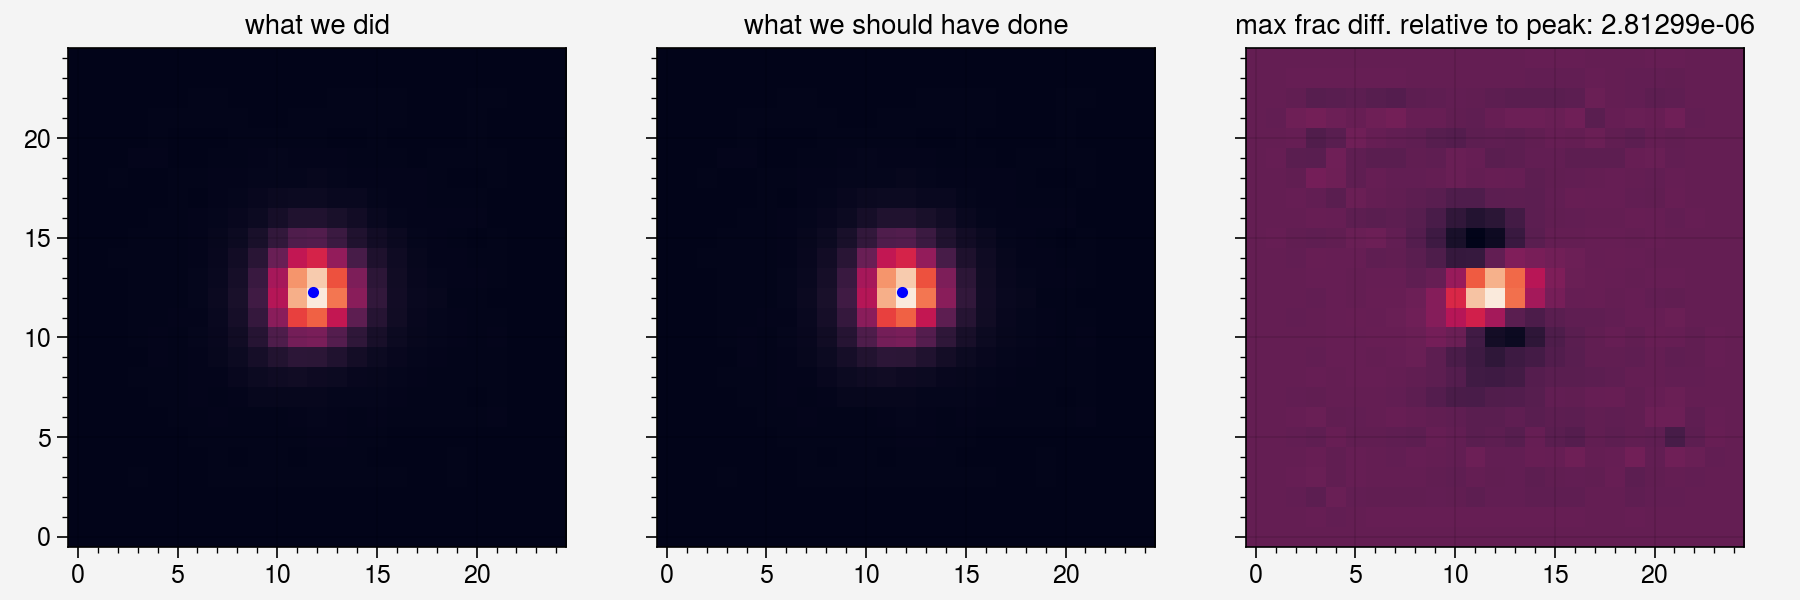

In [118]:
fig, axs = pplt.subplots(nrows=1, ncols=3, figsize=(9, 3))

vmin = min(np.min(psf_im), np.min(psf_im_corr))
vmax = max(np.max(psf_im), np.max(psf_im_corr))

axs[0].imshow(psf_im, cmap="rocket", vmin=vmin, vmax=vmax, origin="lower")
axs[0].plot(jac.col0, jac.row0, 'b.')
axs[0].set_title("what we did")
axs[1].imshow(psf_im_corr, cmap="rocket", vmin=vmin, vmax=vmax, origin="lower")
axs[1].plot(jac_corr.col0, jac_corr.row0, 'b.')
axs[1].set_title("what we should have done")
axs[2].imshow((psf_im - psf_im_corr)/vmax, cmap="rocket", origin="lower")
axs[2].set_title("max frac diff. relative to peak: %g" % (np.max(np.abs((psf_im - psf_im_corr)/vmax))))

In [119]:
fit["T"], fit_corr["T"], fit["T"]-fit_corr["T"]

(0.3408300859261457, 0.3408309630596386, -8.771334928936447e-07)

In [120]:
fit["e"], fit_corr["e"], fit["e"] - fit_corr["e"]

(array([0.02278915, 0.01539274]),
 array([0.02278008, 0.01540812]),
 array([ 9.06674092e-06, -1.53866380e-05]))

## Look at Many

In [121]:
def _compare_at_point(*, pmod, x, y):
    psf_im, fit, jac = _render_piff(
        x=x,
        y=y,
        pmod=pmod,
        wcs_color=1.1,
        psf_color=1.1,
        psf_color_name="GI_COLOR",
    )

    psf_im_corr, fit_corr, jac_corr = _render_piff(
        x=x,
        y=y,
        pmod=pmod,
        wcs_color=1.6,
        psf_color=1.1,
        psf_color_name="GI_COLOR",
    )
    return (
        fit["e1"] - fit_corr["e1"],
        fit["e2"] - fit_corr["e2"],
        fit["T"] - fit_corr["T"],
    )

In [122]:
import tqdm

rng = np.random.default_rng(seed=10)

dg1 = []
dg2 = []
dT = []
for i in tqdm.tqdm(range(len(info["src_info"]))):
    pmod = piff.read(info["src_info"][iind]["piff_path"])
    for _ in range(10):
        x = rng.uniform(low=48, high=2048-48)
        y = rng.uniform(low=48, high=4096-48)
        dd = _compare_at_point(pmod=pmod, x=x, y=y)
        dg1.append(dd[0])
        dg2.append(dd[1])
        dT.append(dd[2])

100%|██████████| 182/182 [00:43<00:00,  4.14it/s]


Text(0.5, 1.0, 'T: mn,sd = (9.20501e-08, 2.93752e-06)')

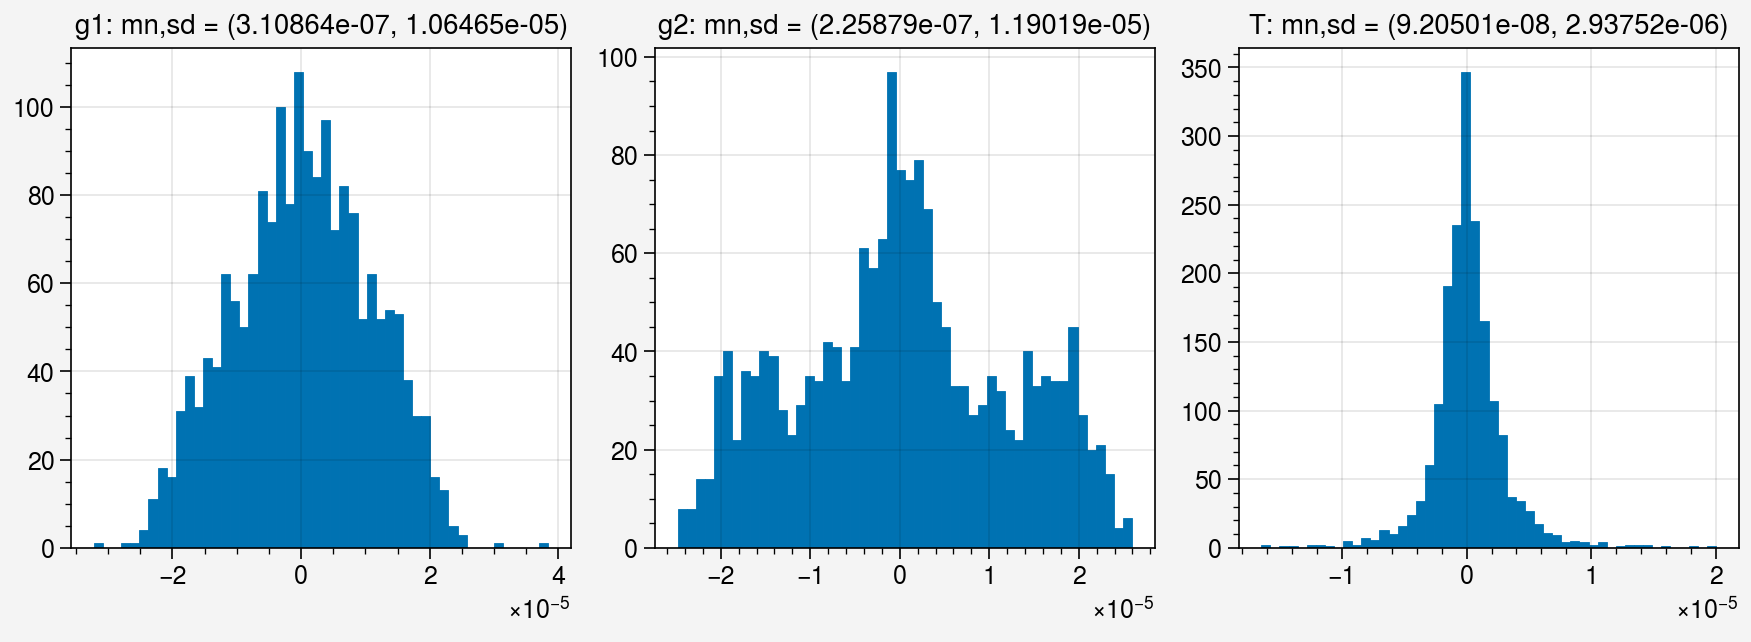

In [123]:
fig, axs = pplt.subplots(nrows=1, ncols=3, share=0)

axs[0].hist(dg1, bins=50)
axs[0].set_title(
    "g1: mn,sd = (%g, %g)" % (np.mean(dg1), np.std(dg1))
)
axs[1].hist(dg2, bins=50)
axs[1].set_title(
    "g2: mn,sd = (%g, %g)" % (np.mean(dg2), np.std(dg2))
)
axs[2].hist(dT, bins=50)
axs[2].set_title(
    "T: mn,sd = (%g, %g)" % (np.mean(dT), np.std(dT))
)